#### Dependencias

In [285]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import DMatrix, train, cv, plot_importance
import seaborn

In [286]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import DMatrix, train, cv, plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt

In [287]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

#### Variables

In [288]:
DATAPATH = Path(os.getcwd()).parent / 'data'
SEED = 1399

#### Leer datos

In [289]:
df = pd.read_csv(DATAPATH / 'train.csv').drop('Id', axis=1)
print(f'Filas: {df.shape[0]:,}')
print(f'Columnas: {df.shape[1]:,}')
df.head(5)

Filas: 1,460
Columnas: 80


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Modelo baseline

In [290]:
for col in df.columns:
    # Si la columna es de tipo 'object' (categórica) o 'bool' (booleana)
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        # Convertir la columna en variables dummy
        dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)
        # Eliminar la columna original del DataFrame
        df = df.drop(col, axis=1)
        # Añadir las variables dummy al DataFrame
        df = pd.concat([df, dummies], axis=1)

print(df)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [291]:
for col in df.columns:
    # Si la columna es de tipo 'bool' (booleana)
    if df[col].dtype == 'bool':
        # Convertir la columna en variables dummy
        dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)
        # Eliminar la columna original del DataFrame
        df = df.drop(col, axis=1)
        # Añadir las variables dummy al DataFrame
        df = pd.concat([df, dummies], axis=1)

print(df)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [292]:
for col in df.columns:
    # Si la columna es de tipo 'bool' (booleana)
    if df[col].dtype == 'bool':
        # Convertir la columna booleana en 0s y 1s
        df[col] = df[col].astype(int)

print(df)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [293]:
# Eliminar filas con NaN
df = df.dropna(axis=0)
print("\nDataFrame después de eliminar filas con NaN:")
print(df)


DataFrame después de eliminar filas con NaN:
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

     

In [294]:
df = df.dropna(axis=1)
print("\nDataFrame después de eliminar columnas con NaN:")
print(df)


DataFrame después de eliminar columnas con NaN:
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

  

In [295]:
X, y = df.drop(['SalePrice'], axis=1), df['SalePrice']

In [296]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV_True,MSZoning_RH_True,MSZoning_RL_True,MSZoning_RM_True,Street_Pave_True,Alley_Pave_True,LotShape_IR2_True,LotShape_IR3_True,LotShape_Reg_True,LandContour_HLS_True,LandContour_Low_True,LandContour_Lvl_True,Utilities_NoSeWa_True,LotConfig_CulDSac_True,...,KitchenQual_Gd_True,KitchenQual_TA_True,Functional_Maj2_True,Functional_Min1_True,Functional_Min2_True,Functional_Mod_True,Functional_Sev_True,Functional_Typ_True,FireplaceQu_Fa_True,FireplaceQu_Gd_True,FireplaceQu_Po_True,FireplaceQu_TA_True,GarageType_Attchd_True,GarageType_Basment_True,GarageType_BuiltIn_True,GarageType_CarPort_True,GarageType_Detchd_True,GarageFinish_RFn_True,GarageFinish_Unf_True,GarageQual_Fa_True,GarageQual_Gd_True,GarageQual_Po_True,GarageQual_TA_True,GarageCond_Fa_True,GarageCond_Gd_True,GarageCond_Po_True,GarageCond_TA_True,PavedDrive_P_True,PavedDrive_Y_True,PoolQC_Fa_True,PoolQC_Gd_True,Fence_GdWo_True,Fence_MnPrv_True,Fence_MnWw_True,MiscFeature_Othr_True,MiscFeature_Shed_True,MiscFeature_TenC_True,SaleType_CWD_True,SaleType_Con_True,SaleType_ConLD_True,SaleType_ConLI_True,SaleType_ConLw_True,SaleType_New_True,SaleType_Oth_True,SaleType_WD_True,SaleCondition_AdjLand_True,SaleCondition_Alloca_True,SaleCondition_Family_True,SaleCondition_Normal_True,SaleCondition_Partial_True
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,0,0,1,0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,0,0,1,0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,0,0,1,0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0

In [297]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [298]:
# Crear un objeto PCA
pca = PCA()

# Ajustar el PCA a los datos
pca.fit(X)

# Obtener la varianza explicada acumulada
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)


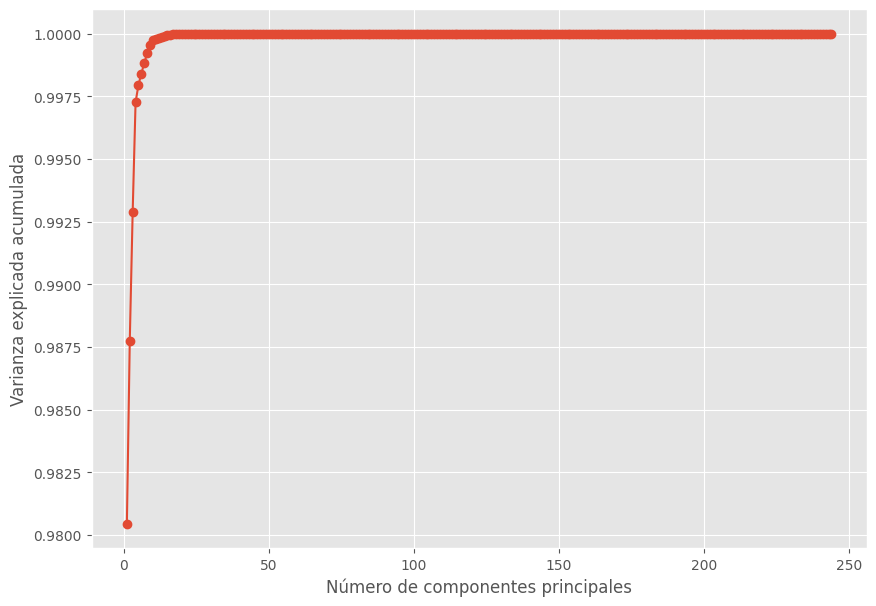

In [299]:
# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

In [300]:
# Determinar el número de componentes principales para retener
# Aquí, retenemos el número de componentes hasta que se explique el 95% de la varianza
n_components = np.where(explained_variance_ratio_cumsum > 0.95)[0][0] + 1
print(f'Número de componentes principales a retener: {n_components}')

Número de componentes principales a retener: 1


In [301]:
pca_optimal = PCA(n_components=n_components)

In [302]:
# Ajustar y transformar los datos
X_pca = pca_optimal.fit_transform(X)

In [303]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1121, dtype: int64

In [304]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=SEED)
print(f'Train: {X_train.shape}')
print(f'Train: {X_test.shape}')

Train: (896, 1)
Train: (225, 1)


In [274]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [309]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para la búsqueda de cuadrícula
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'objective': ['reg:squarederror'],
    'eval_metric': ['rmse', 'mae'],
    'max_depth': [6, 10, 20],
    'nthread': [24,30,35],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'seed': [SEED],
    'colsample_bytree': [0.5, 0.7, 1.0],
}

In [310]:
import xgboost as xgb

# Crear un objeto XGBRegressor
#xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, seed=SEED)

# Crear un objeto GridSearchCV
#grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV al conjunto de entrenamiento
#grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
#print(grid_search.best_params_)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
{'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 10, 'nthread': 24, 'objective': 'reg:squarederror', 'seed': 1399, 'subsample': 0.5}


{'colsample_bytree': 0.5, 'eta': 0.01, 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 10, 'nthread': 24, 'objective': 'reg:squarederror', 'seed': 1399, 'subsample': 0.5}

In [ ]:
#params = {
#    'eta': 0.01,
#    'objective': 'reg:squarederror',
#    'tree_method': 'hist',
#    'eval_metric': ['rmse', 'mae'],
#    'nthread': 24,
#    'seed': SEED,
#    'verbosity': 1
#}

In [311]:
cv_results = cv(
#    params=params,
    params=grid_search.best_params_,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=10,
    verbose_eval=10,
    show_stdv=False
)

[0]	train-rmse:78463.21984	test-rmse:78281.71571
[10]	train-rmse:72918.77811	test-rmse:73074.32715
[20]	train-rmse:67846.08279	test-rmse:68276.59846
[30]	train-rmse:63387.51507	test-rmse:64101.84638
[40]	train-rmse:59334.03825	test-rmse:60356.84361
[50]	train-rmse:55489.69733	test-rmse:56810.68915
[60]	train-rmse:52060.18326	test-rmse:53611.90887
[70]	train-rmse:48901.18648	test-rmse:50748.06908
[80]	train-rmse:46077.44841	test-rmse:48210.01699
[90]	train-rmse:43510.03480	test-rmse:45933.52347
[100]	train-rmse:41141.00513	test-rmse:43836.81471
[110]	train-rmse:39061.54197	test-rmse:42052.64511
[120]	train-rmse:37107.18527	test-rmse:40400.49654
[130]	train-rmse:35323.97623	test-rmse:38916.99620
[140]	train-rmse:33698.77205	test-rmse:37585.12934
[150]	train-rmse:32251.49922	test-rmse:36413.68993
[160]	train-rmse:30937.61571	test-rmse:35365.75403
[170]	train-rmse:29754.82755	test-rmse:34402.42645
[180]	train-rmse:28725.32374	test-rmse:33614.26504
[190]	train-rmse:27713.45918	test-rmse:328

In [312]:
print(cv_results.columns)

Index(['train-rmse-mean', 'train-rmse-std', 'test-rmse-mean', 'test-rmse-std'], dtype='object')


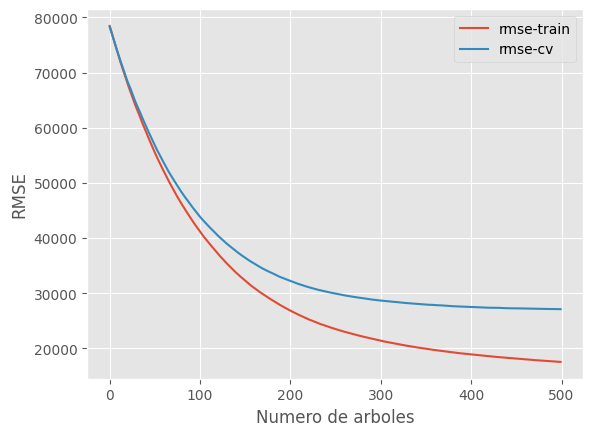

In [313]:
plt.plot(cv_results[['train-rmse-mean', 'test-rmse-mean']], label=['rmse-train', 'rmse-cv'])
plt.legend()
plt.xlabel('Numero de arboles')
plt.ylabel('RMSE')
plt.show()

In [314]:
model = train(
#    params=params,
    params=grid_search.best_params_,
    dtrain=dtrain,
    evals=[(dtrain,'train'), (dtest,'eval')],
    early_stopping_rounds=10,
    num_boost_round=700,
    verbose_eval=10
)

[0]	train-rmse:78483.42259	eval-rmse:80009.54981
[10]	train-rmse:72858.86814	eval-rmse:74398.17127
[20]	train-rmse:67691.99462	eval-rmse:69333.67982
[30]	train-rmse:63127.03292	eval-rmse:64816.94317
[40]	train-rmse:59011.67544	eval-rmse:60889.28045
[50]	train-rmse:55074.47500	eval-rmse:57086.08939
[60]	train-rmse:51635.87303	eval-rmse:53815.60039
[70]	train-rmse:48409.25259	eval-rmse:50818.37697
[80]	train-rmse:45522.19436	eval-rmse:48234.47109
[90]	train-rmse:42901.61240	eval-rmse:45904.79949
[100]	train-rmse:40557.11391	eval-rmse:43939.05571
[110]	train-rmse:38462.91713	eval-rmse:42135.28799
[120]	train-rmse:36512.97794	eval-rmse:40576.42866
[130]	train-rmse:34746.88953	eval-rmse:39113.45217
[140]	train-rmse:33189.87738	eval-rmse:37901.13219
[150]	train-rmse:31780.87355	eval-rmse:36859.22734
[160]	train-rmse:30475.93417	eval-rmse:35885.30016
[170]	train-rmse:29247.46737	eval-rmse:35055.10779
[180]	train-rmse:28208.47053	eval-rmse:34338.38829
[190]	train-rmse:27202.07952	eval-rmse:337

In [315]:
predictions = model.predict(dtest)
print(f'RMSE: {mean_squared_error(dtest.get_label(), predictions, squared=False):} USD')

RMSE: 28860.8671875 USD


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

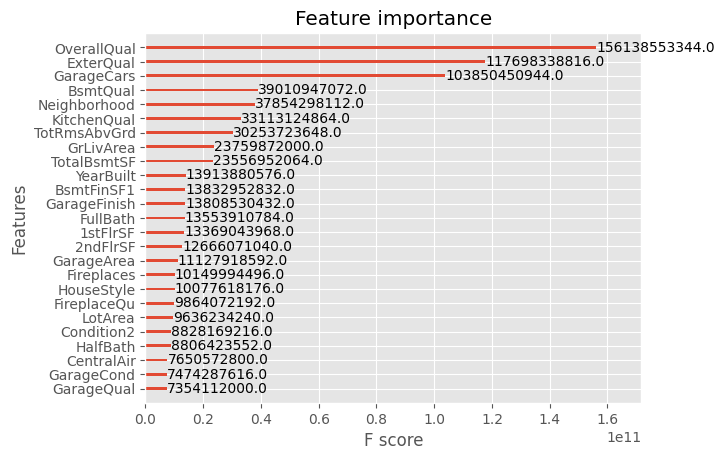

In [316]:
plot_importance(model, importance_type='gain', max_num_features=25)